In [60]:
from collections import namedtuple
import glob
import random

from gym.wrappers import RescaleAction, TimeLimit
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import pandas as pd
import seaborn as sns
from stable_baselines3 import TD3
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from tqdm import tqdm

from environments import ARESEASequential, ResetActuators, ResetActuatorsToDFD

## Run Simulation

In [2]:
def load_sequential(model_name, algorithm=TD3, init="dfd"):

    ModelSetup = namedtuple("ModelSetup", ["name","env","model"])

    log_dir = f"models/{model_name}"

    def make_env():
        env = ARESEASequential(
            backend="simulation",
            backendargs={"measure_beam": "direct"}
        )
        if init == "dfd":
            env = ResetActuatorsToDFD(env, k1=10)
        elif init == "zero":
            env = ResetActuators(env)
        elif init == "random":
            pass
        env = TimeLimit(env, max_episode_steps=300)
        env = RescaleAction(env, -1, 1)
        return env

    env = DummyVecEnv([make_env])
    env = VecNormalize.load(f"{log_dir}/vec_normalize.pkl", env)
    env.training = False
    env.norm_reward = False

    model = algorithm.load(f"{log_dir}/model")

    return ModelSetup(model_name, env, model)

In [3]:
def pack_dataframe(fn):
    def wrapper(setup, problem=None):
        observations, rewards, incoming, misalignments = fn(setup, problem=problem)
        observations = np.array(observations)

        df = pd.DataFrame(np.arange(len(observations)), columns=["step"])
        df["q1"] = observations[:,0]
        df["q2"] = observations[:,1]
        df["cv"] = observations[:,2]
        df["q3"] = observations[:,3]
        df["ch"] = observations[:,4]
        df["mup_x"] = observations[:,5]
        df["mup_y"] = observations[:,6]
        df["sigmap_x"] = observations[:,7]
        df["sigmap_y"] = observations[:,8]
        df["mu_x"] = observations[:,9]
        df["mu_y"] = observations[:,10]
        df["sigma_x"] = observations[:,11]
        df["sigma_y"] = observations[:,12]
        df["reward"] = [np.nan] + rewards
        for k in incoming.keys():
            df["incoming_"+k] = float(incoming[k])
        df["misalignment_q1"] = misalignments[0]
        df["misalignment_q2"] = misalignments[1]
        df["misalignment_q3"] = misalignments[2]
        df["misalignment_screen"] = misalignments[4]

        return df
    
    return wrapper

In [4]:
@pack_dataframe
def run(setup, problem=None):
    env, model = setup.env, setup.model

    if problem is not None:
        if "initial" in problem:
            env.get_attr("unwrapped")[0].next_initial = problem["initial"]
        if "incoming" in problem:
            env.get_attr("backend")[0].next_incoming = problem["incoming"]
        if "misalignments" in problem:
            env.get_attr("backend")[0].next_misalignments = problem["misalignments"]
        if "desired" in problem:
            env.get_attr("unwrapped")[0].next_desired = problem["desired"]

    observations = []
    rewards = []

    observation = env.reset()

    observations.append(env.unnormalize_obs(observation).squeeze())
    incoming = env.get_attr("backend")[0]._incoming.parameters
    misalignments = env.get_attr("backend")[0].misalignments

    done = False
    while not done:
        action, _ = model.predict(observation, deterministic=True)
        observation, reward, done, info = env.step(action)

        observations.append(env.unnormalize_obs(observation).squeeze())
        rewards.append(reward[0])

    observations[-1] = env.unnormalize_obs(info[0]["terminal_observation"].squeeze())

    return observations, rewards, incoming, misalignments

In [5]:
def cache_to_file(fn):
    def wrapper(model_name, **kwargs):
        filename = f".cache_3/{model_name}.pkl"
        
        try:
            evaluation = pd.read_pickle(filename)
            print(f"Read {model_name} from cache file")
        except FileNotFoundError:
            evaluation = fn(model_name, **kwargs)
            evaluation.to_pickle(filename)
        
        return evaluation

    return wrapper

In [6]:
@cache_to_file
def evaluate(model_name, algorithm=TD3, method=None, description=None, init="dfd"):
    setup = load_sequential(model_name, algorithm, init)

    with open("problems_3.json", "r") as f:
        problems = json.load(f)

    evaluation = []
    for i, problem in enumerate(tqdm(problems)):
        result = run(setup, problem=problem)
        result["problem"] = i
        evaluation.append(result)
    evaluation = pd.concat(evaluation)
    evaluation["model"] = setup.name
    if method is not None:
        evaluation["method"] = method
    if description is not None:
        evaluation["description"] = description
    
    return evaluation

In [7]:
todos = [{
        "method": "resettodfd",
        "description": "Reset to DFD (with Adjusted Initial)",
        "models": ["polished-donkey-996", "polar-lake-997", "still-deluge-998"],
        "algorithm": TD3,
        "init": "dfd"
    }]

sequential_evaluation = pd.concat([
    evaluate(
        model,
        algorithm=todo["algorithm"],
        method=todo["method"],
        description=todo["description"],
        init=todo["init"]
    ) for todo in todos for model in todo["models"]
])

Read polished-donkey-996 from cache file
Read polar-lake-997 from cache file
Read still-deluge-998 from cache file


## Load Machine Evaluations

In [8]:
directories = [
    "machine_studies/first_three_all_agents_thirty",
    "machine_studies/next_to_27_polished_donkey"
]

firstthree = pd.concat([pd.read_pickle(path) for path in glob.glob(f"{directories[0]}/*.pkl")])
nextto27 = pd.concat([pd.read_pickle(path) for path in glob.glob(f"{directories[1]}/*.pkl")])

nextto27["problem"] += 22

machine_evaluation = pd.concat([firstthree,nextto27])

machine_evaluation.rename(columns={"model_name": "model"})

machine_evaluation.head()

,step,q1,q2,cv,q3,ch,mup_x,mup_y,sigmap_x,sigmap_y,...,sigma_y,reward,beam_image,model_name,max_episode_steps,measure_beam,problem,model,method,description
0,0,10.000000,-10.000000,10.000000,-6.912348e-09,-6.913231e-09,-4.953762e-14,-3.209174e-14,0.0005,3.944690e-12,...,0.000195,NaN,"[[3.5, 1.5, 0.0, 0.0, 0.0, 0.0, 0.0, 1.5, 1.5,...",polished-donkey-996,30,us,1,polished-donkey-996,resettodfd,Reset to DFD (with Adjusted Initial)
1,1,7.000000,-12.223105,7.006832,-2.838993e-04,5.999892e-04,-4.953762e-14,-3.209174e-14,0.0005,3.944690e-12,...,0.000091,0.7798661,"[[0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0,...",polished-donkey-996,30,us,1,polished-donkey-996,resettodfd,Reset to DFD (with Adjusted Initial)
2,2,4.000706,-11.935585,4.733665,-2.710386e-04,9.698678e-04,-4.953762e-14,-3.209174e-14,0.0005,3.944690e-12,...,0.000042,-0.46572173,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.5, 0.0,...",polished-donkey-996,30,us,1,polished-donkey-996,resettodfd,Reset to DFD (with Adjusted Initial)
3,3,4.161233,-11.313807,4.183193,-4.347263e-05,3.698678e-04,-4.953762e-14,-3.209174e-14,0.0005,3.944690e-12,...,0.000042,0.22168387,"[[0.0, 0.0, 2.0, 2.5, 0.0, 0.0, 0.0, 2.5, 1.0,...",polished-donkey-996,30,us,1,polished-donkey-996,resettodfd,Reset to DFD (with Adjusted Initial)
4,4,4.129065,-11.069790,3.841451,-3.822307e-05,-2.300663e-04,-4.953762e-14,-3.209174e-14,0.0005,3.944690e-12,...,0.000046,0.17436482,"[[0.0, 0.5, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",polished-donkey-996,30,us,1,polished-donkey-996,resettodfd,Reset to DFD (with Adjusted Initial)


## Analyse

In [9]:
sequential_evaluation["location"] = "simulation"
machine_evaluation["location"] = "machine"

evaluation = pd.concat([sequential_evaluation, machine_evaluation])
evaluation = evaluation.reset_index().drop("index", axis=1)

evaluation.head()

,step,q1,q2,cv,q3,ch,mup_x,mup_y,sigmap_x,sigmap_y,...,misalignment_screen,problem,model,method,description,location,beam_image,model_name,max_episode_steps,measure_beam
0,0,10.000000,-10.000000,10.000000,5.049272e-13,4.975862e-14,-4.953762e-14,-3.209174e-14,-2.268001e-12,3.944690e-12,...,0.000237,0,polished-donkey-996,resettodfd,Reset to DFD (with Adjusted Initial),simulation,NaN,NaN,NaN,NaN
1,1,7.664854,-11.290555,7.370315,-2.997844e-04,2.670577e-04,-4.953762e-14,-3.209174e-14,-2.268001e-12,3.944690e-12,...,0.000237,0,polished-donkey-996,resettodfd,Reset to DFD (with Adjusted Initial),simulation,NaN,NaN,NaN,NaN
2,2,6.862143,-11.577105,8.151775,-5.940921e-04,2.914717e-04,-4.953762e-14,-3.209174e-14,-2.268001e-12,3.944690e-12,...,0.000237,0,polished-donkey-996,resettodfd,Reset to DFD (with Adjusted Initial),simulation,NaN,NaN,NaN,NaN
3,3,7.210077,-12.397335,9.254650,-5.790312e-04,2.291428e-04,-4.953762e-14,-3.209174e-14,-2.268001e-12,3.944690e-12,...,0.000237,0,polished-donkey-996,resettodfd,Reset to DFD (with Adjusted Initial),simulation,NaN,NaN,NaN,NaN
4,4,7.371862,-12.939801,9.952576,-5.537235e-04,2.370682e-04,-4.953762e-14,-3.209174e-14,-2.268001e-12,3.944690e-12,...,0.000237,0,polished-donkey-996,resettodfd,Reset to DFD (with Adjusted Initial),simulation,NaN,NaN,NaN,NaN


In [10]:
# Compute MAE
evaluation["delta_mu_x"] = np.abs(evaluation["mup_x"] - evaluation["mu_x"])
evaluation["delta_mu_y"] = np.abs(evaluation["mup_y"] - evaluation["mu_y"])
evaluation["delta_sigma_x"] = np.abs(evaluation["sigmap_x"] - evaluation["sigma_x"])
evaluation["delta_sigma_y"] = np.abs(evaluation["sigmap_y"] - evaluation["sigma_y"])
evaluation["mae"] = (evaluation["delta_mu_x"] + evaluation["delta_mu_y"] + evaluation["delta_sigma_x"] + evaluation["delta_sigma_y"]) / 4

In [11]:
finals = evaluation.groupby(["model","problem","location"]).apply(lambda x: x.loc[x["step"].idxmax()]).drop(["model","location"], axis=1)
finals.drop("problem", axis=1, inplace=True)
finals.head()

step        q1         q2         cv  \
model          problem location                                           
polar-lake-997 0       machine       30  2.815245 -12.054045  15.916696   
                       simulation   300  3.388573 -12.566923  16.724551   
               1       machine       30 -3.292164  -4.300812  -8.510563   
                       simulation   300 -4.679438  -7.379429 -13.703112   
               2       machine       30  7.222610  -3.206225  15.682930   

                                         q3        ch         mup_x  \
model          problem location                                       
polar-lake-997 0       machine    -0.000004  0.001843 -1.212707e-13   
                       simulation -0.000267  0.000405 -1.212707e-13   
               1       machine     0.000287 -0.004585 -1.212707e-13   
                       simulation  0.000122 -0.004394 -1.212707e-13   
               2       machine    -0.000856  0.003202 -1.212707e-13   

                                          mup_y      sigmap_x      sigmap_y  \
model          problem location                                               
polar-lake-997 0       machine    -7.609571e-14  5.677387e-13  6.934697e-13   
                       simulation -7.609571e-14  5.677387e-13  6.934697e-13   
               1       machine    -7.609571e-14  5.000000e-04  6.934697e-13   
                       simulation -7.609571e-14  5.000000e-04  6.934697e-13   
               2       machine    -7.609571e-14  5.677387e-13  5.000000e-04   

                                   ...                           description  \
model          problem location    ...                                         
polar-lake-997 0       machine     ...  Reset to DFD (with Adjusted Initial)   
                       simulation  ...  Reset to DFD (with Adjusted Initial)   
               1       machine     ...  Reset to DFD (with Adjusted Initial)   
                       simulation  ...  Reset to DFD (with Adjusted Initial)   
               2       machine     ...  Reset to DFD (with Adjusted Initial)   

                                                                          beam_image  \
model          problem location                                                        
polar-lake-997 0       machine     [[1.5, 0.5, 0.0, 0.0, 0.0, 2.0, 0.0, 5.0, 0.0,...   
                       simulation                                                NaN   
               1       machine     [[0.5, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 5.0, 0.0,...   
                       simulation                                                NaN   
               2       machine     [[2.5, 0.0, 1.5, 3.0, 1.0, 0.0, 0.5, 1.5, 1.0,...   

                                       model_name  max_episode_steps  \
model          problem location                                        
polar-lake-997 0       machine     polar-lake-997               30.0   
                       simulation             NaN                NaN   
               1       machine     polar-lake-997               30.0   
                       simulation             NaN                NaN   
               2       machine     polar-lake-997               30.0   

                                  measure_beam  delta_mu_x  delta_mu_y  \
model          problem location                                          
polar-lake-997 0       machine              us    0.000007    0.000010   
                       simulation          NaN    0.000011    0.000025   
               1       machine              us    0.000027    0.000020   
                       simulation          NaN    0.000011    0.000039   
               2       machine              us    0.000033    0.000049   

                                   delta_sigma_x  delta_sigma_y       mae  
model          problem location                                            
polar-lake-997 0       machine          0.000039       0.000066  0.000031  
                       simu

In [12]:
after30 = finals.copy()
after30[after30["step"] >= 30] = evaluation.groupby(["model","problem","location"]).apply(lambda x: x[x["step"] == 30]).set_index(["model","problem","location"])
after30.reset_index(inplace=True)

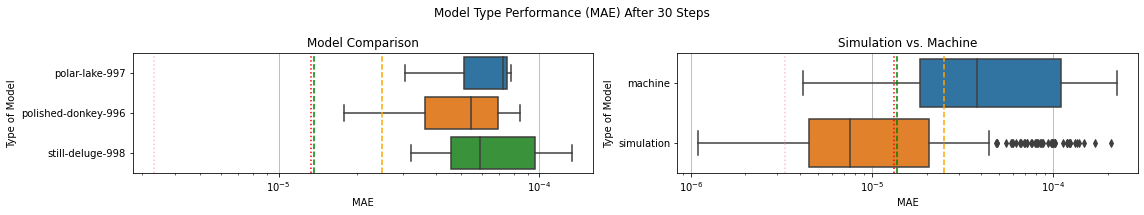

In [16]:
model_comparison = after30[after30["problem"] < 3]
model_comparison = model_comparison[model_comparison["location"] == "machine"]

simulation_vs_machine = after30[after30["model"] == "polished-donkey-996"]

plt.figure(figsize=(16,3))
plt.suptitle("Model Type Performance (MAE) After 30 Steps")
plt.subplot(121)
plt.title("Model Comparison")
sns.boxplot(x="mae", y="model_name", data=model_comparison)
# sns.stripplot(x="mae", y="model_name", size=3, color="0.3", alpha=0.3, linewidth=0, data=model_comparison)
plt.xscale("log")
plt.xlabel("MAE")
plt.ylabel("Type of Model")
plt.axvline(1.37e-5, c="green", ls="--", label="Operator Example")
plt.axvline(2.49e-5, c="orange", ls="--", label="Agent Machine Example")
plt.axvline(3.3198e-6*4, c="red", ls="dotted", label="Pixel Size at Binning 4")
plt.axvline(3.3198e-6, c="pink", ls="dotted", label="Pixel Size at Binning 1")
plt.gca().xaxis.grid()
plt.gca().set_axisbelow(True)
plt.subplot(122)
plt.title("Simulation vs. Machine")
sns.boxplot(x="mae", y="location", data=simulation_vs_machine)
# sns.stripplot(x="mae", y="location", size=3, color="0.3", alpha=0.3, linewidth=0, data=after30.reset_index())
plt.xscale("log")
plt.xlabel("MAE")
plt.ylabel("Type of Model")
plt.axvline(1.37e-5, c="green", ls="--", label="Operator Example")
plt.axvline(2.49e-5, c="orange", ls="--", label="Agent Machine Example")
plt.axvline(3.3198e-6*4, c="red", ls="dotted", label="Pixel Size at Binning 4")
plt.axvline(3.3198e-6, c="pink", ls="dotted", label="Pixel Size at Binning 1")
plt.gca().xaxis.grid()
plt.gca().set_axisbelow(True)
plt.tight_layout()
plt.show()

In [41]:
from environments.simulation import ExperimentalArea
ea = ExperimentalArea()
ea._segment.AREABSCR1.extent

(-0.0040634352, 0.0040634352, -0.002495838, 0.002495838)

In [59]:
model_comparison[["model","problem","mae"]]

,model,problem,mae
0,polar-lake-997,0,0.000031
2,polar-lake-997,1,0.000078
4,polar-lake-997,2,0.000072
303,polished-donkey-996,0,0.000055
305,polished-donkey-996,1,0.000084
307,polished-donkey-996,2,0.000018
651,still-deluge-998,0,0.000032
653,still-deluge-998,1,0.000133
655,still-deluge-998,2,0.000059


In [68]:
model_comparison.loc[0,"beam_image"].shape

(514, 616)

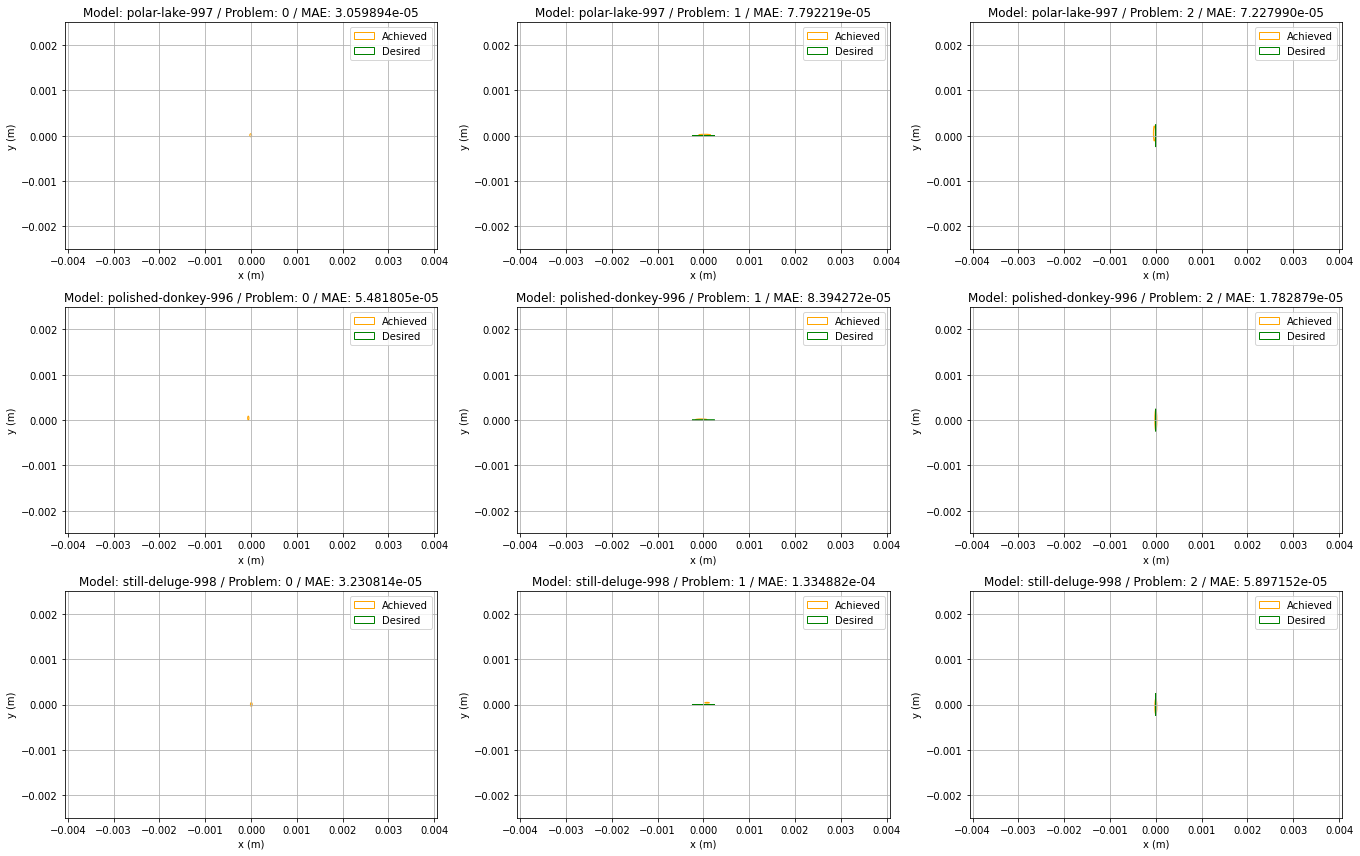

In [69]:
def plot_example(achieved, desired):
    def plot_ellipse(params, color=None, label=None):
        ellipse = Ellipse((params[0],params[1]), params[2], params[3], fill=False, color=color, label=label)
        plt.gca().add_patch(ellipse)

    extent = (-0.0040634352,0.0040634352,-0.002495838,0.002495838)

    plt.xlim([extent[0], extent[1]])
    plt.ylim([extent[2], extent[3]])
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    plt.grid()
    plot_ellipse(achieved, color="orange", label="Achieved")
    plot_ellipse(desired, color="green", label="Desired")        
    plt.legend()

plt.figure(figsize=(19,12))
for i, model in enumerate(model_comparison["model"].unique()):
    for j, problem in enumerate(model_comparison["problem"].unique()):
        row = model_comparison[(model_comparison["model"] == model) & (model_comparison["problem"] == problem)]
        achieved = [row["mu_x"].squeeze(), row["mu_y"].squeeze(), row["sigma_x"].squeeze(), row["sigma_y"].squeeze()]
        desired = [row["mup_x"].squeeze(), row["mup_y"].squeeze(), row["sigmap_x"].squeeze(), row["sigmap_y"].squeeze()]
        mae = row["mae"].squeeze()

        plt.subplot(3, 3, 3*i+j+1)
        plt.title(f"Model: {model} / Problem: {problem} / MAE: {mae:05e}")
        plot_example(achieved, desired)
plt.tight_layout()
plt.show()

(514, 616)
(514, 616)
(514, 616)
(514, 616)
(514, 616)
(514, 616)
(514, 616)
(514, 616)
(514, 616)


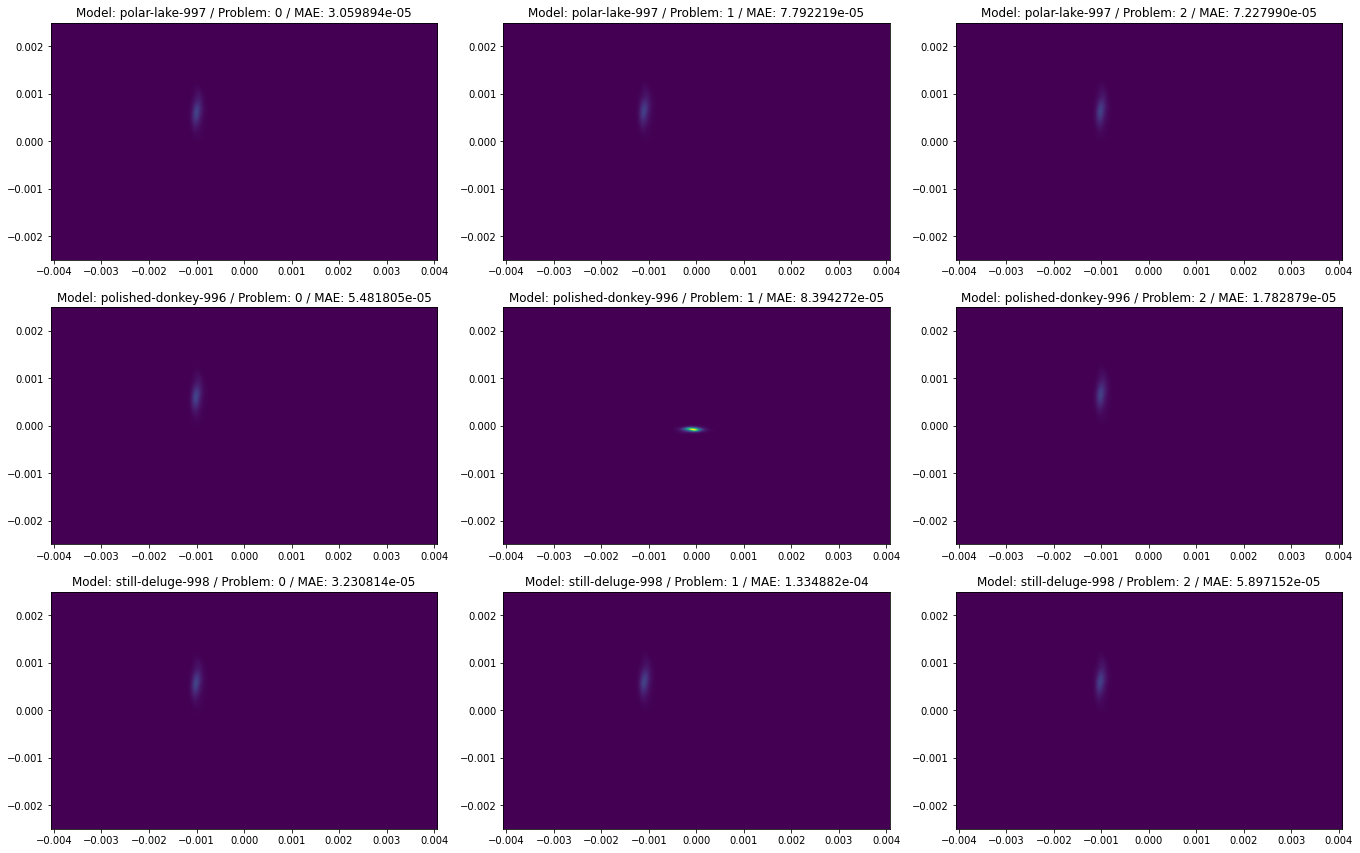

In [63]:
plt.figure(figsize=(19,12))
for i, model in enumerate(model_comparison["model"].unique()):
    for j, problem in enumerate(model_comparison["problem"].unique()):
        row = model_comparison[(model_comparison["model"] == model) & (model_comparison["problem"] == problem)]
        screen = row["beam_image"].squeeze()
        print(screen.shape)
        mae = row["mae"].squeeze()
        plt.subplot(3, 3, 3*i+j+1)
        plt.title(f"Model: {model} / Problem: {problem} / MAE: {mae:05e}")
        plt.imshow(screen, vmin=0, vmax=2048, extent=(-0.0040634352,0.0040634352,-0.002495838,0.002495838))
plt.tight_layout()
plt.show()

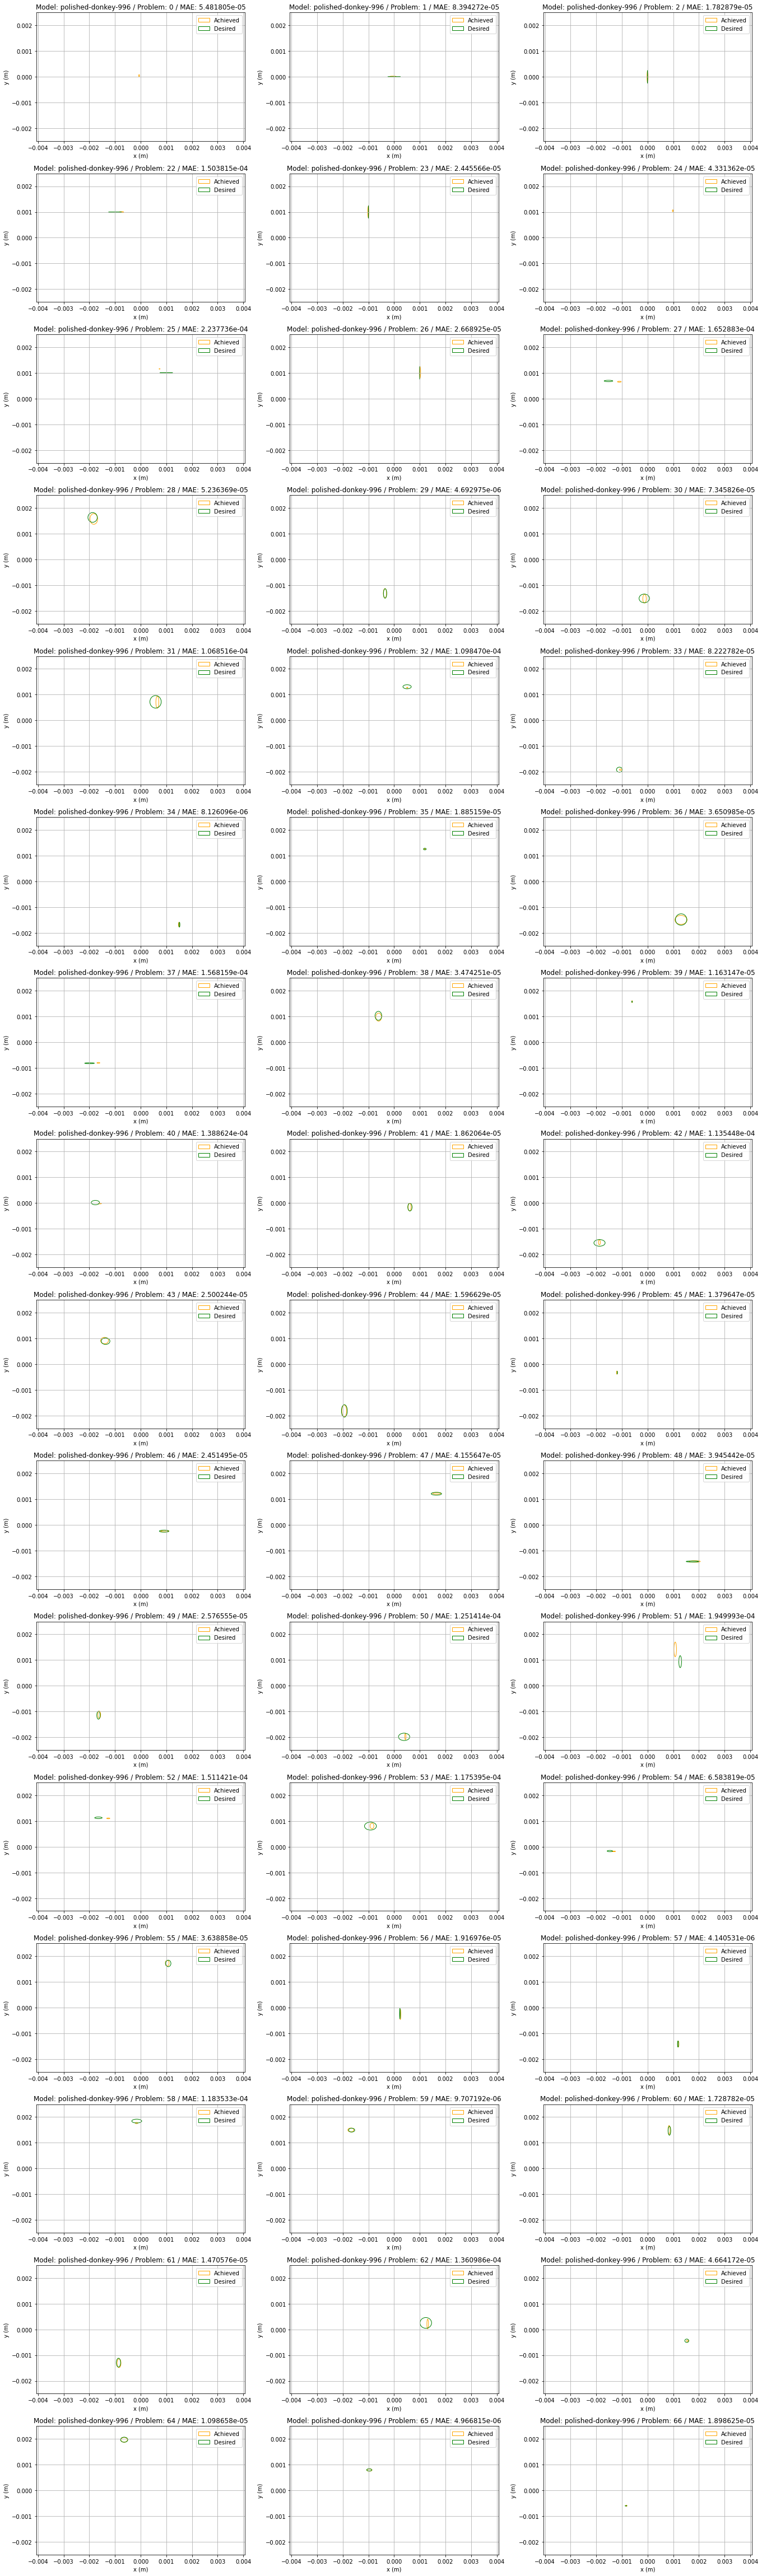

In [72]:
def plot_example(achieved, desired):
    def plot_ellipse(params, color=None, label=None):
        ellipse = Ellipse((params[0],params[1]), params[2], params[3], fill=False, color=color, label=label)
        plt.gca().add_patch(ellipse)

    extent = (-0.0040634352,0.0040634352,-0.002495838,0.002495838)

    plt.xlim([extent[0], extent[1]])
    plt.ylim([extent[2], extent[3]])
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    plt.grid()
    plot_ellipse(achieved, color="orange", label="Achieved")
    plot_ellipse(desired, color="green", label="Desired")        
    plt.legend()

machine_examples = simulation_vs_machine[simulation_vs_machine["location"] == "machine"]

n_rows = int(np.ceil(len(machine_examples)/3))
plt.figure(figsize=(19,12/3*n_rows))
for i, model in enumerate(machine_examples["model"].unique()):
    for j, problem in enumerate(machine_examples["problem"].unique()):
        row = machine_examples[(machine_examples["model"] == model) & (machine_examples["problem"] == problem)]
        achieved = [row["mu_x"].squeeze(), row["mu_y"].squeeze(), row["sigma_x"].squeeze(), row["sigma_y"].squeeze()]
        desired = [row["mup_x"].squeeze(), row["mup_y"].squeeze(), row["sigmap_x"].squeeze(), row["sigmap_y"].squeeze()]
        mae = row["mae"].squeeze()

        plt.subplot(n_rows, 3, 3*i+j+1)
        plt.title(f"Model: {model} / Problem: {problem} / MAE: {mae:05e}")
        plot_example(achieved, desired)
plt.tight_layout()
plt.show()